In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%matplotlib inline

In [3]:
import optax
import numpy as onp
import jax.numpy as jnp
import jax.random
import jax_md
from jax import jit, vmap, grad, lax
import matplotlib.pyplot as plt
import pickle
import mendeleev

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import data
data_raw = data.get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [6]:
from collections import defaultdict
opt = optax.chain(optax.clip_by_global_norm(jnp.float32(1.0)), optax.adam(jnp.float32(3e-4), jnp.float32(0.95)))

In [7]:
def compute_species_params(charge):
  element = mendeleev.element(charge)
  return [charge, element.atomic_volume, element.group_id, element.period]

In [8]:
def prepare_tensors(atoms):
  lattice = atoms.cell.array.astype(onp.float32)
  displacement, shift = jax_md.space.periodic_general(lattice.T, fractional_coordinates=False)
  species_params = jnp.array([compute_species_params(int(charge)) for charge in atoms.get_atomic_numbers()],
                             dtype=jnp.float32)
  neighbor_fn, init_fn_bp, energy_fn_bp = jax_md.energy.graph_network_neighbor_list(
    displacement_fn=displacement,
    nodes=species_params,
    box_size=21,
    r_cutoff=4.9,
    dr_threshold=0.2)
  neighbor = neighbor_fn(atoms.positions, extra_capacity=3)
  
  @jit
  def train_energy_fn(params, R):
    _neighbor = neighbor_fn(R, neighbor)
    return energy_fn_bp(params, R, _neighbor)

  # Vectorize over states, not parameters.
  vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

  grad_fn = grad(train_energy_fn, argnums=1)
  force_fn = lambda params, R, **kwargs: -grad_fn(params, R)
  vectorized_force_fn = vmap(force_fn, (None, 0))
  
  @jit
  def energy_loss(params, R, energy_targets):
    return jnp.mean((vectorized_energy_fn(params, R) - energy_targets) ** 2)

  @jit
  def force_loss(params, R, force_targets):
    dforces = vectorized_force_fn(params, R) - force_targets
    return jnp.mean(jnp.sum(dforces ** 2, axis=(1, 2)))
  
  @jit
  def loss(params, R, targets):
    return energy_loss(params, R, targets[0]) + force_loss(params, R, targets[1])
  
  @jit
  def update_step(params, opt_state, R, labels):
    updates, opt_state = opt.update(grad(loss)(params, R, labels),
                                    opt_state)
    return optax.apply_updates(params, updates), opt_state

  
  @jit
  def update_epoch(params_and_opt_state, batches):
    def inner_update(params_and_opt_state, batch):
      params, opt_state = params_and_opt_state
      b_xs, b_labels = batch

      return update_step(params, opt_state, b_xs, b_labels), 0
    return lax.scan(inner_update, params_and_opt_state, batches)[0]

  return init_fn_bp, neighbor_fn, vectorized_energy_fn, energy_loss, update_epoch

In [9]:
data_processed = {}
for key, defect_vars in data_raw.items():
  energies = []
  coordinates = []
  forces = []
  for traj in defect_vars:
    energies.append(jnp.array([a.get_potential_energy() for a in traj], dtype=jnp.float32))
    coordinates.append(jnp.array([a.positions for a in traj], dtype=jnp.float32))
    forces.append(jnp.array([a.get_forces() for a in traj], dtype=jnp.float32))
  data_processed[key] = (
    jnp.concatenate(energies), jnp.concatenate(coordinates), jnp.concatenate(forces))

In [10]:
tensors_per_id = {k: prepare_tensors(v[0][0]) for k, v in data_raw.items()}

In [11]:
key = jax.random.PRNGKey(42)
BASE='id18'
initial_coords = jnp.array(data_raw[BASE][0][0].positions)
base_funcs  = tensors_per_id[BASE]
neighbor = base_funcs[1](initial_coords, extra_capacity=3)
params = base_funcs[0](key, initial_coords, neighbor)

In [12]:
opt_state = opt.init(params)
train_energy_error = []

In [13]:
from IPython import display

In [14]:
BATCH_SIZE = 24
@jit
def make_batches(lookup, ERF):
  batch_Rs = []
  batch_Es = []
  batch_Fs = []

  for i in range(0, len(lookup), BATCH_SIZE):
    if i + BATCH_SIZE > len(lookup):
      break

    idx = lookup[i:i + BATCH_SIZE]

    batch_Rs += [ERF[1][idx]]
    batch_Es += [ERF[0][idx]]
    batch_Fs += [ERF[2][idx]]

  return jnp.stack(batch_Rs), (jnp.stack(batch_Es), jnp.stack(batch_Fs))

In [ ]:
for epoch in range(1000):
  for defect_id in data_processed.keys():
    lookup = onp.arange(len(data_processed[defect_id][0]))
    onp.random.shuffle(lookup)
    batches = make_batches(lookup, data_processed[defect_id])
    params, opt_state = tensors_per_id[defect_id][4](
      (params, opt_state), batches)
      # Total eV
    train_energy_error += [onp.sqrt(tensors_per_id[defect_id][3](
        params, data_processed[defect_id][1], data_processed[defect_id][0]))]
    print(defect_id, train_energy_error[-1])
  display.clear_output(wait=True)
  with open("gnn-traj.pkl", "wb") as params_file:
    pickle.dump(params, params_file)

id31 0.9177365
id42 25.561283
id1 6.7520657
id27 2.8361573
id12 17.323086
id11 4.1830983
id47 25.833622
id28 5.0526466
id26 8.562157
id2 1.0005409
id0 25.540878
id25 12.640333
id10 11.00307
id37 15.770291
id32 6.752003
id20 13.066332
id3 2.524308
id44 16.904099
id19 8.999199
id4 7.0526958
id38 10.015715
id8 6.354145
id39 1.1064991
id6 13.512871
id34 3.2536938
id14 27.654043
id43 5.2045803
id9 6.165595
id35 7.8983064
id15 1.2376448
id29 0.88748556
id18 8.367489
id21 8.158903
id24 7.5145636
id40 10.103228
id36 26.697416
id46 1.2484958
id30 20.925545
id16 4.974459
id41 2.047617
id7 6.345469
id45 23.652191
id33 9.825732


In [27]:
predicted_E = []
true_E = []
for defect_id in data_processed.keys():
  predicted_E.append(tensors_per_id[defect_id][2](params, data_processed[defect_id][1]))
  true_E.append(data_processed[defect_id][0])
predicted_E = jnp.concatenate(predicted_E)
true_E = jnp.concatenate(true_E)
  
min_energy = min(true_E.min(), predicted_E.min())
max_energy = max(true_E.max(), predicted_E.max())
plot_range = onp.linspace(min_energy, max_energy, 10)       

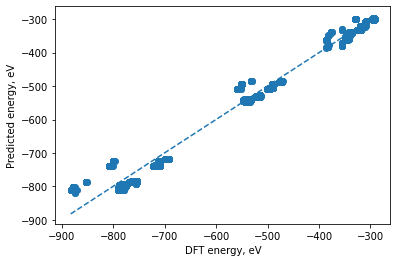

In [28]:
fig, ax = plt.subplots()
ax.scatter(true_E, predicted_E)
plt.plot(plot_range, plot_range, '--')      
ax.set_ylabel("Predicted energy, eV")
ax.set_xlabel("DFT energy, eV");